# Advanced Energy Data Analysis

This advanced tutorial builds on the basics of energy data analysis. <br>
Here, you will learn more about advanced visualization techniques, statistical analyses, and data processing methods.


:::{admonition} Learning outcomes By the end of this tutorial, you will:

- Customize visualizations using advanced parameters
- Explore and process time-series energy data
- Perform statistical analyses and trend identification




## Setting Up

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import datetime as dt
import seaborn as sns
import shutil
from cycler import cycler
from collections.abc import Iterable
from sklearn import linear_model
from jupytercards import display_flashcards
from jupyterquiz import display_quiz
import pygit2
print('Versions of used modules: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('seaborn', sns.__version__)
print('shutil',shutil)
print('cycler',cycler)
print('pygit2', pygit2.__version__)
print("\n")
print('All modules imported successfully!')

Versions of used modules: 
numpy 1.26.4
matplotlib 3.9.2
pandas 2.2.2
datetime <module 'datetime' from 'C:\\Users\\Genesis\\anaconda3\\Lib\\datetime.py'>
seaborn 0.13.2
shutil <module 'shutil' from 'C:\\Users\\Genesis\\anaconda3\\Lib\\shutil.py'>
cycler <function cycler at 0x000002564416CA40>
pygit2 1.16.0


All modules imported successfully!


## Loading the Data

This time we will use the dataset `household_data_1min_singleindex.csv`. <br>
You can download the data here https://data.open-power-system-data.org/household_data/2020-04-15 {cite:p}`minde_household_2017`
<br>
<br>
As you can see, the dataset is quite large. However, we can use filters to display a specific time period (e.g. from 2015-10-16 to 2017-02-09). <br>
This will significantly reduce the file size.

<img src="img/household_data_1min_filter.png" alt="household_data_filter" style="width: 50%; height: auto; margin: 10px; border: 2px solid black;">

Make sure the dataset file (`household_data_1min_singleindex.csv`) is in your working directory!

In [2]:
# Load the example dataset
df = pd.read_csv('household_data_1min_singleindex_filtered.csv')
print("File loaded successfully!")


File loaded successfully!


## Explore Load Profile of an Industrial Company

In [3]:
df['time'] = df.utc_timestamp.apply(#
    lambda x: #
    dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['weekday'] = df['time'].dt.weekday

df['industrialP'] = df['DE_KN_industrial1_grid_import'].diff()


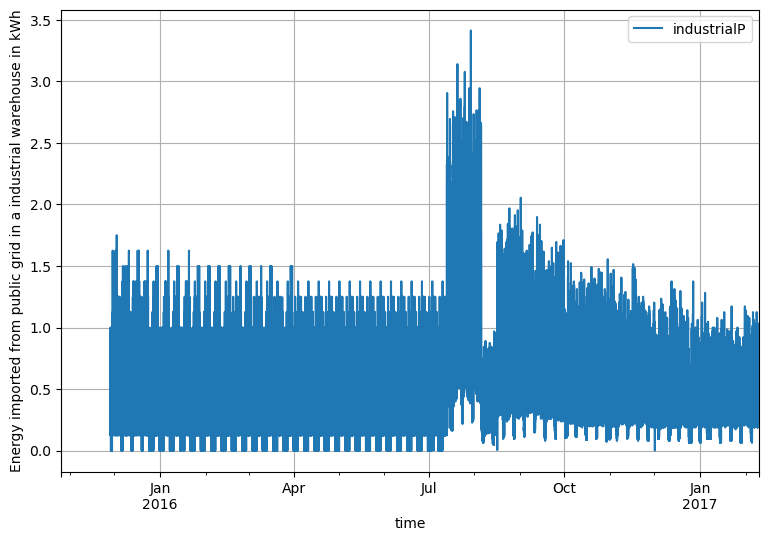

In [4]:
df.plot(x='time',y='industrialP', figsize=(9,6))
plt.ylabel('Energy imported from public grid in a industrial warehouse in kWh');
plt.grid()
plt.show()

In [5]:
res = df['time'][1]-df['time'][0]
print('Resolution '+str(res))

Resolution 0 days 00:01:00


In [6]:
dW = 1000*60*60 # kWh in J
dt = 60 # hour in sec
dW_dt_faktor = dW/dt
print('Umrechnungsfaktor zu W ist ' + str(dW_dt_faktor))

Umrechnungsfaktor zu W ist 60000.0


In [7]:
df['industrialP'] = dW_dt_faktor*0.001*df['DE_KN_industrial1_grid_import'].diff()

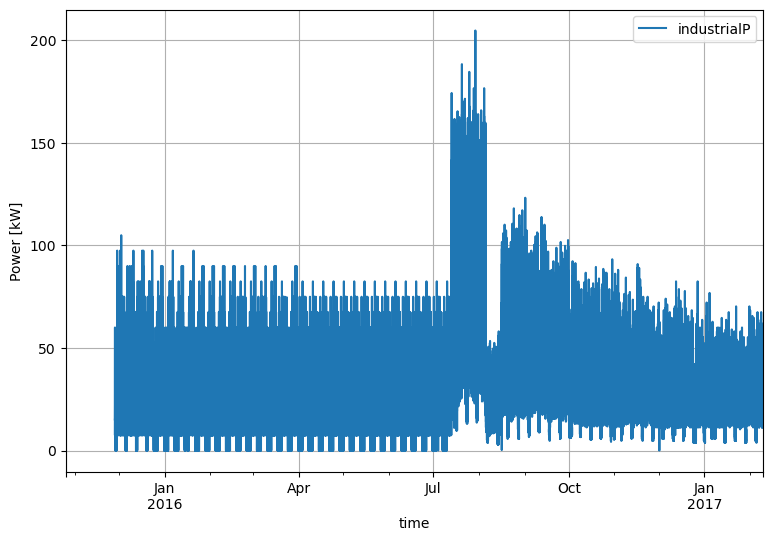

In [8]:
df.plot(x='time',y='industrialP', figsize=(9,6))
plt.ylabel('Power [kW]')
plt.grid()
plt.show()

It is difficult to interpret with so many data points, and unfortunately, the x-axis is cluttered with missing data. Additionally, the axis is not utilized effectively. <br>
Exclude missing values (NaN) to improve clarity and accuracy.

In [9]:
df2 = df.dropna(subset=['time','industrialP'])

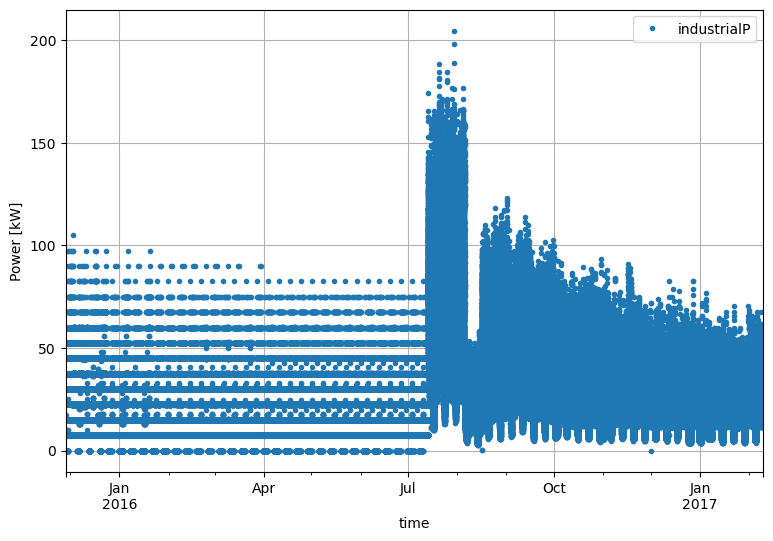

In [10]:
df2.plot(x='time',y='industrialP', style='.', figsize=(9,6))
plt.ylabel('Power [kW]')
plt.grid()
plt.show()

## Comparison with Local Solar Generation

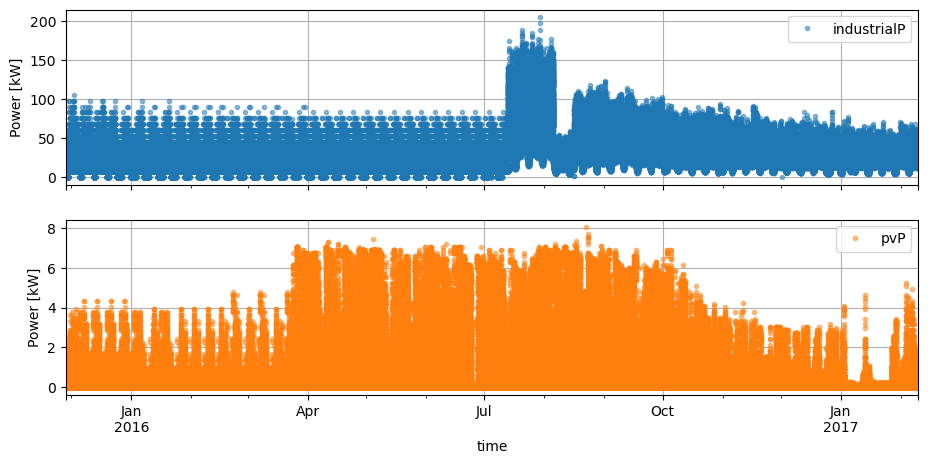

In [11]:
df.rename(columns = {'DE_KN_industrial1_pv_1':'pv'}, inplace = True)
df['pvP'] = dW_dt_faktor*0.001*df['pv'].diff()
df2 = df.dropna(subset=['time','industrialP','pvP'])

axes = df2.plot(x = 'time', y= ['industrialP','pvP'], marker='.',#
                         alpha=0.5, linestyle='None',#
                         figsize=(11,5), subplots=True, grid=True)
for ax in axes:
    ax.set_ylabel('Power [kW]')

## Detailed Analysis of the Load Profile for January 2017

First, set the timestamp as the index.

In [12]:
df2.set_index('time', inplace = True)

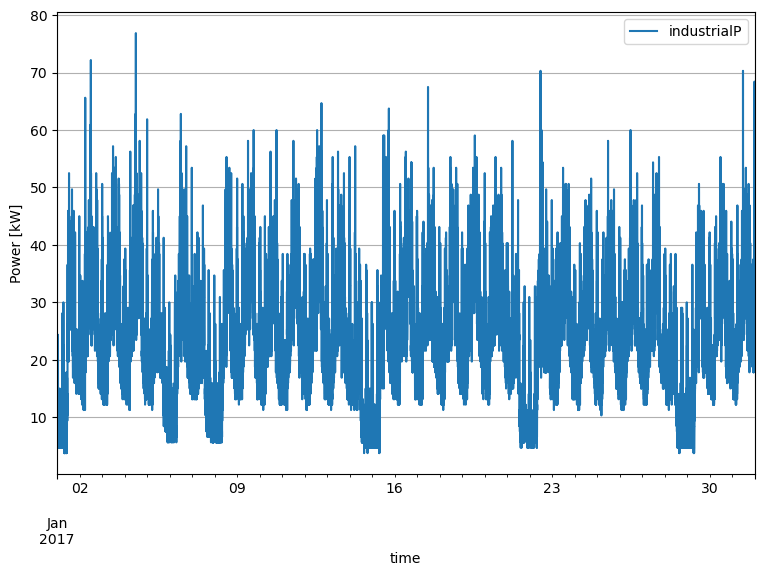

In [13]:
ax = df2.loc['2017-1'].plot(y = 'industrialP',linestyle='-', figsize=(9,6))
plt.ylabel('Power [kW]')
plt.grid()
plt.show()

### Getting Weekdays from matplotlib

In [14]:
import matplotlib.dates as mdates

### Create weekly grid in the chart

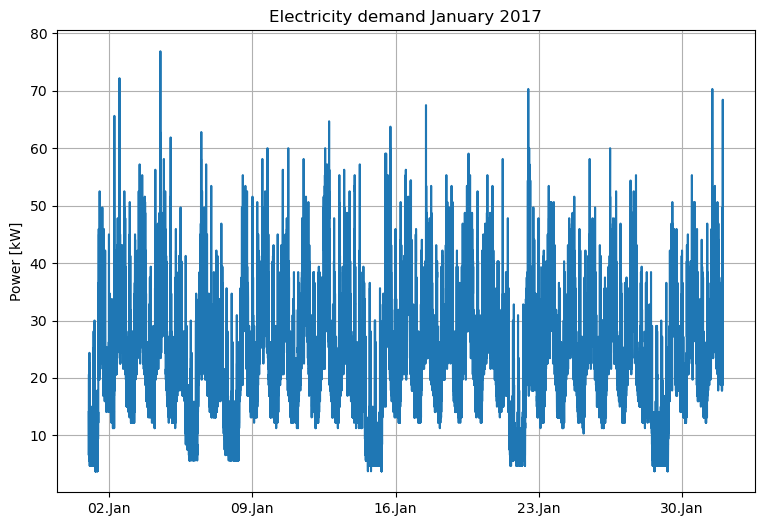

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(df2.loc['2017-1', 'industrialP'], linestyle='-')
ax.set_ylabel('Power [kW]')
ax.set_title('Electricity demand January 2017')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%b'))
plt.grid()
plt.show()

There seems to be an increased demand on Sundays as well—this can be questioned if one is familiar with the operation, to determine whether, for example, work is being conducted on Sundays.

## Seasonal Variations with Boxplots


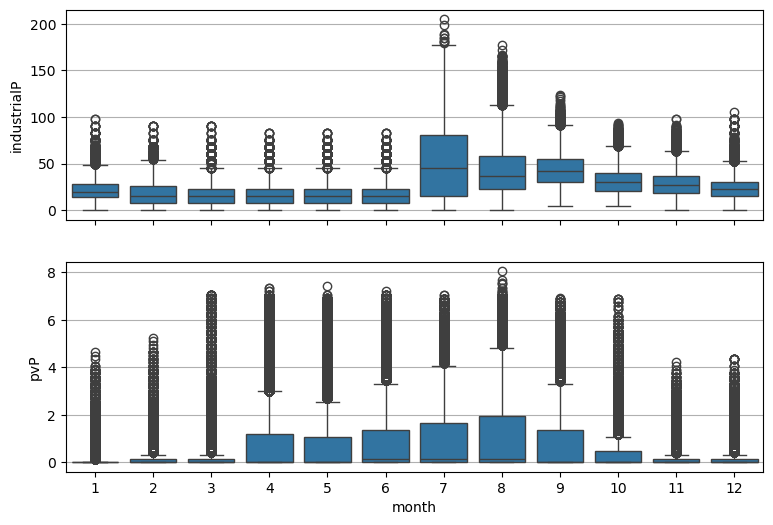

In [16]:

fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

for name, ax in zip(['industrialP', 'pvP'], axes):
    ax.grid()
    sns.boxplot(data=df2, x='month', y=name, ax=ax)
if ax != axes[-1]:
    ax.set_xlabel('')

Over several months, no conclusions can be drawn due to missing data.

Solar generation is naturally higher in summer than in winter, which is a plausible trend.

If more solar panel area were available (e.g., additional roof surfaces, façades, or even rented spaces), the share of local generation could be increased.

It is promising to see that demand also appears to be higher in summer, which means increased solar generation could help offset this higher demand effectively.

## Weekday Dependency of the Load Profile

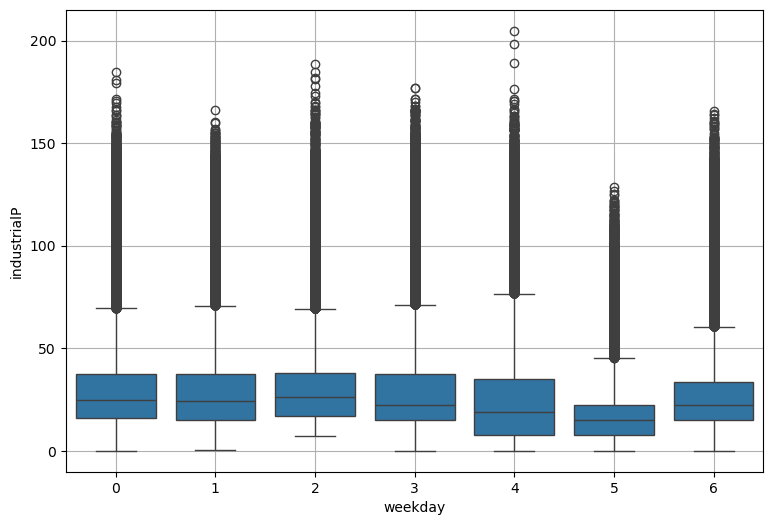

In [17]:
plt.figure(figsize=(9,6))
sns.boxplot(data = df2, x = 'weekday', y= 'industrialP');
plt.grid()

Here, we can see that consumption is significantly lower on weekends, but there are a few extreme power values. This suggests that either a ramp-up with high demand occurs during these times or these are avoidable power peaks.

## Creating Moving Averages: Data Windowing

A sliding window is a useful method for smoothing data and identifying trends. For example, the mean is calculated within the window, which then moves one step forward, and the mean is recalculated for the next set of values.

Choosing a larger window size includes more neighboring values in the calculation, producing a smoother curve. This helps reduce short-term fluctuations and makes it easier to identify broader patterns or trends in the data, which can be particularly helpful for analysis and decision-making.

In [18]:
df2_1d = df2['industrialP'].rolling(24*60, center=True).mean()

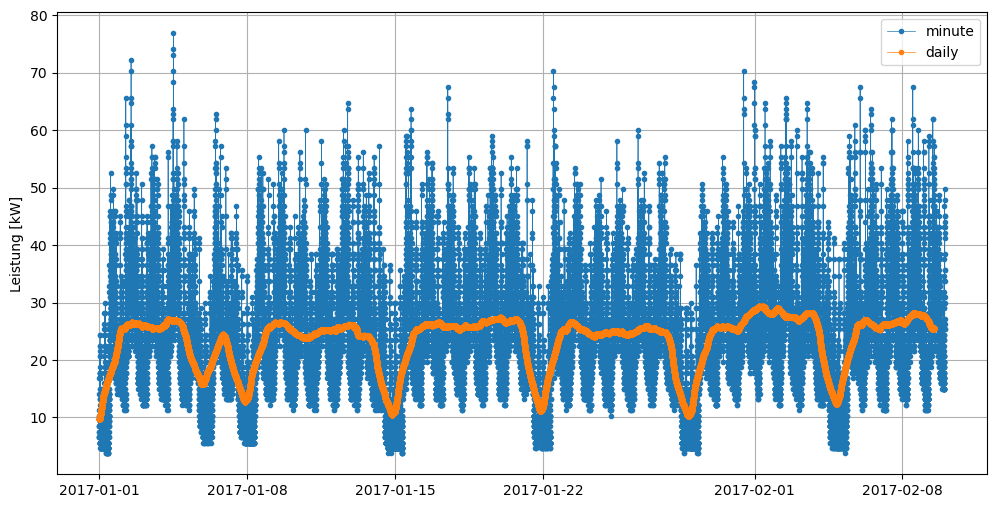

In [19]:
start, end = '2017-01', '2017-02'
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df2.loc[start:end, 'industrialP'], 
       marker = '.', linestyle = '-', linewidth = 0.5,
        label = 'minute')
ax.plot(df2_1d.loc[start:end],
       marker = '.', linestyle = '-', linewidth = 0.5,
        label = 'daily')
ax.set_ylabel('Leistung [kW]')
ax.legend()
ax.grid()

The result of windowing has the same resolution as the original dataset but is slightly smoothed.

This makes it easier to identify trends and recurring patterns.

In some cases, datasets are very high-resolution (e.g., for non-intrusive load monitoring, NILM). In such cases, the data must first be averaged to make them manageable on smaller machines.

## Histogram of Power Values

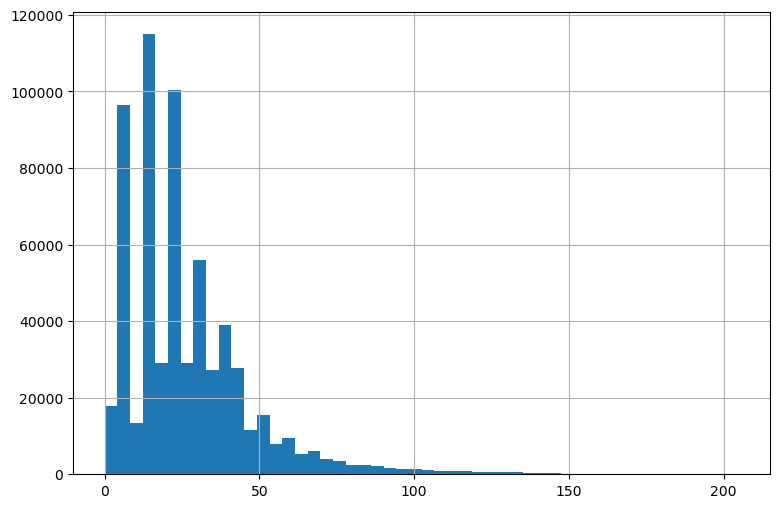

In [20]:
plt.figure(figsize=(9,6))
df2['industrialP'].hist(bins = 50)
plt.show()

## Heatmaps

In [21]:
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype('int64').values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

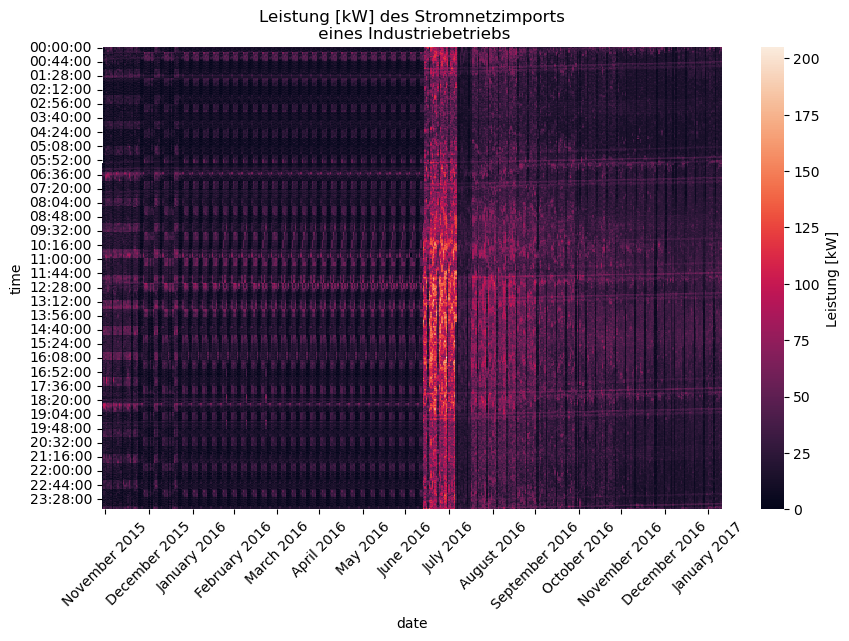

In [22]:
hm_df = pd.DataFrame({'industrialP': df2['industrialP']})
hm_df['date'] = df2.index.date
hm_df['time'] = df2.index.time
hm_piv = hm_df.pivot(index = 'time', columns = 'date', values = 'industrialP')
fig, ax = plt.subplots(figsize = (10,6))
sns.heatmap(hm_piv, cbar_kws={'label': 'Leistung [kW]'})
ax.set_title('Power [kW] of grid import for an industrial facility')
set_date_ticks(ax, hm_piv.columns[0], hm_piv.columns[-1] ,axis='x', freq='1ME', date_format='%B %Y')
ax.tick_params(axis="x", rotation=45)

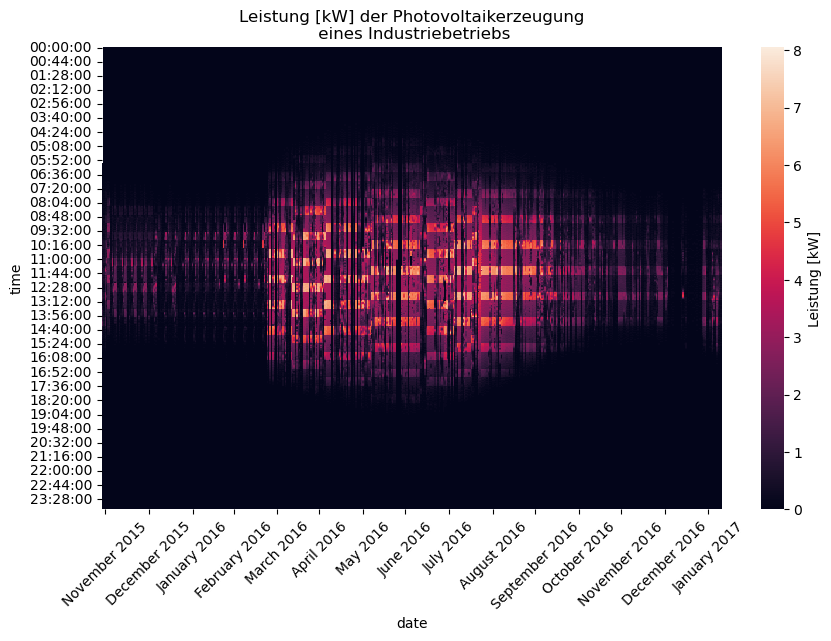

In [23]:
hm2_df = pd.DataFrame({'pvP': df2['pvP']})
hm2_df['date'] = df2.index.date
hm2_df['time'] = df2.index.time
hm2_piv = hm2_df.pivot(index = 'time', columns = 'date', values = 'pvP')
fig1, ax1 = plt.subplots(figsize = (10,6))
sns.heatmap(hm2_piv, cbar_kws={'label': 'Leistung [kW]'})
ax1.set_title('Power [kW] of grid import for an industrial facility')
set_date_ticks(ax1, hm2_piv.columns[0], hm2_piv.columns[-1] ,axis='x', freq='1ME', date_format='%B %Y')
ax1.tick_params(axis="x", rotation=45)